In [1]:
import torch
import torch.backends.cudnn as cudnn
import torchvision
import cv2 
from matplotlib import pyplot as plt
import os,sys, glob
import numpy as np
import PIL
import random
from PIL import Image
import gc
import h5py
from sklearn.model_selection import train_test_split
from typing import Generator
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPU 1 to use
from core.data_loader import sem_generator,patch_generator, load_whole_image
from core.crop_image import scale_f_num_0to3,crop_image, make_image_crop
from core.utils import seed_everything
from core.patch_generate import *

In [4]:
#seed = 0
#seed_everything(seed) # Seed 고정

In [8]:
with h5py.File("train_Samsung_SNU_patches_SET7.hdf5",'r') as f:
    # print(f)
    noisy_images = np.array(f['noisy_images'])
print(noisy_images.shape)

(22000, 256, 256)


In [5]:
data_path="./Samsung_SNU_1474x3010_aligned"
crop_data_path="./Samsung_SNU_cropped"
os.makedirs(crop_data_path,exist_ok=True)
# random_crop = torchvision.transforms.RandomCrop(size=256)
crop_size = 256
# for test, make just 2 crop image
num_crop= 2 #500


In [22]:
num_test_image = 3
for set_num in sorted(os.listdir(data_path)):
    set_path = os.path.join(data_path,set_num)
    image_list = sorted(os.listdir(set_path)) # 16
    image_list = list(filter(lambda x : "F64" not in x,image_list))
    image_list = list(filter(lambda x : "checkpoints" not in x,image_list))
    len_train = len(image_list)-num_test_image*2
    
    train_noisy_patch, train_target_patch = None, None
    val_noisy_patch, val_target_patch = None, None
    test_noisy_patch, test_target_patch = None, None
    noisy_f_num = ['F8','F16','F32']
    for i,f_num in enumerate(noisy_f_num): # f_num 마다 구분
        val_index, test_index = return_val_test_index()
        #print("======",i, f_num, set_path)
        #print("======",val_index,test_index)
        for image_idx, image_path in enumerate(glob.glob(f"{set_path}/{f_num}*.png")):
            # print(image_idx,image_path)
            start_idx = i * num_crop
            end_idx = (i+1) * num_crop
            noisy, target = make_patch_of_image(data_path,image_path,num_crop)
            if image_idx == val_index:
                #print(f"This is val image")
                val_noisy_patch = append_tensor(val_noisy_patch,noisy)
                val_target_patch = append_tensor(val_target_patch,target)
            elif image_idx == test_index:
                #print(f"This is test image")
                test_noisy_patch = append_tensor(test_noisy_patch,noisy)
                test_target_patch = append_tensor(test_target_patch,target)
            else :
                train_noisy_patch = append_tensor(train_noisy_patch,noisy)
                train_target_patch = append_tensor(train_target_patch,target)
            noisy, target = None, None
            gc.collect()
            #print(im_cropped.shape)
        
    print(f"create dataset of {set_num}")
    print(f"[train] noisy & target(clean) patch shape")
    print(f"{train_noisy_patch.shape} and {train_target_patch.shape}")
    print(train_noisy_patch[0].max(), train_target_patch[1].min())
    print(f"[val] noisy & target(clean) patch shape")
    print(f"{val_noisy_patch.shape} and {val_target_patch.shape}")
    print(val_noisy_patch[0].max(), val_target_patch[1].min())
    print(f"[test] noisy & target(clean) patch shape")
    print(f"{test_noisy_patch.shape} and {test_target_patch.shape}")
    print(test_noisy_patch[0].max(), test_target_patch[1].min())
    save_to_hdf5(train_noisy_patch, train_target_patch,set_num,'train')
    sys.exit(0)
    save_to_hdf5(val_noisy_patch, val_target_patch,set_num,'val')
    save_to_hdf5(test_noisy_patch, test_target_patch,set_num,'test')
    #x_train, x_test, y_train, y_test = train_test_split(noisy_patch,target_patch,test_size=0.08,shuffle=True)
    #print(x_train.shape, x_test.shape)
    
    
    

create dataset of SET1
[train] noisy & target(clean) patch shape
torch.Size([84, 256, 256]) and torch.Size([84, 256, 256])
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
[val] noisy & target(clean) patch shape
torch.Size([6, 256, 256]) and torch.Size([6, 256, 256])
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
[test] noisy & target(clean) patch shape
torch.Size([6, 256, 256]) and torch.Size([6, 256, 256])
tensor(1., device='cuda:0') tensor(0., device='cuda:0')


SystemExit: 0

In [24]:
with h5py.File("./train_Samsung_SNU_patches_SET1.hdf5") as f:
    print(f['clean_images'].shape,f['noisy_images'].shape)

(84, 256, 256) (84, 256, 256)


torch.Size([6, 256, 256])


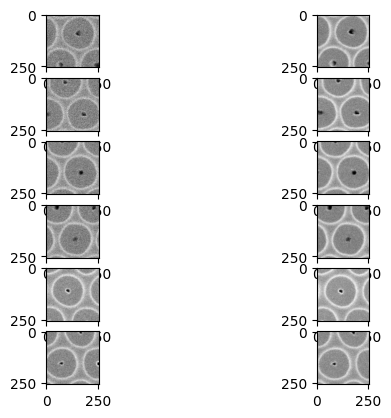

In [12]:
print(test_noisy_patch.shape)
for i in range(6):
    plt.subplot(6,2,2*i+1)
    plt.imshow(test_noisy_patch[i].cpu().numpy(),cmap='gray')
    plt.subplot(6,2,2*i+2)
    plt.imshow(test_target_patch[i].cpu().numpy(),cmap='gray')

torch.Size([6, 256, 256])


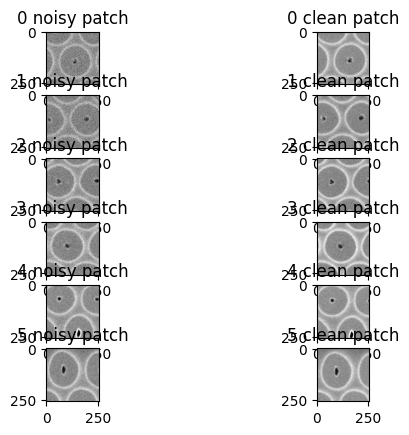

In [13]:
print(val_noisy_patch.shape)
for i in range(6):
    plt.subplot(6,2,2*i+1)
    plt.title(f"{i} noisy patch")
    plt.imshow(val_noisy_patch[i].cpu().numpy(),cmap='gray')
    plt.subplot(6,2,2*i+2)
    plt.title(f"{i} clean patch")
    plt.imshow(val_target_patch[i].cpu().numpy(),cmap='gray')

In [ ]:

for set_num in sorted(os.listdir(data_path)):
    print(set_num)
    set_path = os.path.join(data_path,set_num)
    image_list = sorted(os.listdir(set_path)) # 16
    image_list = list(filter(lambda x : "F64" not in x,image_list))
    image_list = list(filter(lambda x : "checkpoints" not in x,image_list))
    noisy_patch = torch.Tensor(num_crop*len(image_list),256,256).cuda() 
    target_patch = torch.Tensor(num_crop*len(image_list),256,256).cuda()
    # print(len(image_list))
    gc.collect()
    for image_idx,image_name in enumerate(image_list):
        image_path = os.path.join(data_path,set_num,image_name)
        image_num = image_name.split("_")[1]
        clean_path = os.path.join(data_path,set_num,f"F64_{image_num}")
        im = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        target_im = cv2.imread(clean_path,cv2.IMREAD_GRAYSCALE)
        im, target_im = im/255. ,target_im / 255.
        #patch_save_path = os.path.join(crop_data_path,set_num,image_name)
        
        for i in range(num_crop):
            im_cropped, target_im_cropped = read_image_and_crop(im,target_im)
            #print(im_cropped.shape)
            index = i + image_idx*num_crop
            noisy_patch[index],target_patch[index] = im_cropped,target_im_cropped
            #print(im_cropped.shape)
    print(f"create dataset of {set_num}")
    print(f"noisy & target(clean) patch shape")
    print(f"{noisy_patch.shape} and {target_patch.shape}")
    print(noisy_patch[0].max(), noisy_patch[1].min())
    sys.exit(0)
    #x_train, x_test, y_train, y_test = train_test_split(noisy_patch,target_patch,test_size=0.08,shuffle=True)
    #print(x_train.shape, x_test.shape)
    noisy_patch, target_patch = noisy_patch.cpu().numpy(), target_patch.cpu().numpy()
    with h5py.File(f"Samsung_SNU_patches_{set_num}.hdf5","w") as f:
        f.create_dataset("noisy_images", noisy_patch.shape, dtype='f', data=noisy_patch)
        f.create_dataset("clean_images", target_patch.shape, dtype='f', data=target_patch)
    gc.collect()
    

In [ ]:
import h5py
import os,sys
#test_size = 2000
for set_num in sorted(os.listdir(data_path)):
    print(f" ===== {set_num} ====== ")
    with h5py.File(f"./Samsung_SNU_patches_{set_num}.hdf5","r") as f:
        gc.collect()
        print(set_num,f['noisy_images'].shape, f['clean_images'].shape) #
        noisy_images,clean_images = np.array(f['noisy_images']), np.array(f['clean_images']) 
        x_train, x_test, y_train, y_test = train_test_split(noisy_images,clean_images,test_size=0.08,random_state = seed, shuffle=True) # Not work! - why?
        """
        x_train, x_test = f['noisy_images'][:-test_size], f['noisy_images'][-test_size:]
        y_train, y_test = f['clean_images'][:-test_size], f['clean_images'][-test_size:]
        """
        print("===== data split into train/test ====="
            "\ntrain dataset(x,y) : ",x_train.shape,y_train.shape, 
              "\n test dataset(x,y) : ", x_test.shape, y_test.shape) 
        print(f" ==== {set_num} =====",np.unique(x_train[-1]),"\n",np.unique(x_train[0]),x_train[0].shape,type(x_train),file=open("log.txt","w"))
        with h5py.File(f"./train_Samsung_SNU_patches_{set_num}.hdf5","w") as tr_f:
            print(f"create train_dataset of {set_num}")
            tr_f.create_dataset("noisy_images", x_train.shape, dtype='f', data=x_train)
            tr_f.create_dataset("clean_images", y_train.shape, dtype='f', data=y_train)
        with h5py.File(f"./test_Samsung_SNU_patches_{set_num}.hdf5","w") as te_f:
            print(f"create test_dataset of {set_num}")
            te_f.create_dataset("noisy_images", x_test.shape, dtype='f', data=x_test)
            te_f.create_dataset("clean_images", y_test.shape, dtype='f', data=y_test)

In [ ]:
print("complete")

In [ ]:
plt.imshow(target_patch.cpu()[0],cmap='gray')

In [ ]:
plt.imshow(noisy_patch.cpu()[0],cmap='gray')